In [1]:
# make external scripts auto reload
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fastbm25 import fastbm25
import re
from tqdm.notebook import tqdm

from candidate_generation import *

## Loading data + helper functions

In [3]:
def print_scheme(v, name=None):
    cpu, r = metrics(v)
    if name is None:
        print(f'{cpu:>8.2f} {r:>8.2%}')
    else:
        print(f'{name:>40}: {cpu:>8.2f} {r:>8.2%}')

def metrics(v):
    cpu = len(v) / test_data.customer_id.nunique()
    r = recall(v, test_data)
    return cpu, r

In [4]:
BASE_PATH = '../../data/'
# DATA_PATH = BASE_PATH + "parquet/"
DATA_PATH = BASE_PATH + "sample_0.05/"


transactions_original = pd.read_parquet(DATA_PATH + 'transactions_train.parquet')
customers_original = pd.read_parquet(DATA_PATH + 'customers.parquet')
articles_original = pd.read_parquet(DATA_PATH + 'articles.parquet')
articles_txt_original = pd.read_csv(BASE_PATH + 'original/articles.csv')

transactions = transactions_original.copy()
customers = customers_original.copy()
articles = articles_original.copy()
articles_txt = articles_txt_original.copy()

In [19]:
# clean slate
transactions = transactions_original.copy()
customers = customers_original.copy()
articles = articles_original.copy()

# split data into test en training
test_week = 104
num_train_weeks = 50
train_weeks = np.arange(test_week - num_train_weeks, test_week)
test_data = transactions[transactions.week == test_week][['customer_id', 'article_id']].drop_duplicates()
test_X = pd.Series(test_data['customer_id'].unique(), name='customer_id')
train_data = transactions[transactions.week.isin(train_weeks)].copy()
train_data = add_relative_week(train_data)

# add bin/clip features
train_data['clipped_price'] = train_data['price'].clip(0, 150)
train_data['binned_price'] = pd.cut(train_data.price, bins=[0, 4, 5, 6, 7, 8, 9, 10, 13, 15, 18, 20, 25, 30, 40, 60, np.inf])
customers['age_group'] = pd.cut(customers.age, bins=[0, 40, 60, 100], labels=["Young Adult", "Middle Aged", "Old"])

# add purchase behaviour features
article_max_price = train_data.groupby('article_id')['binned_price'].max().to_frame('article_price')
customer_avg_price = train_data.groupby("customer_id").price.mean().to_frame("preferred_price")
buys_for_kids = (
    pd.merge(
        train_data[["customer_id", "article_id"]],
        articles[["article_id", "index_group_name"]],
        on="article_id",
    )
    .groupby("customer_id")
    .index_group_name.agg(lambda x: 1 in x.values)
    .to_frame("buys_for_kids")
)
articles = pd.merge(articles, article_max_price, on='article_id', how='left')
customers = pd.merge(customers, customer_avg_price, on='customer_id', how='left')
customers = pd.merge(customers, buys_for_kids, on='customer_id', how='left')

# add article descriptor feature
articles_txt['detail_desc'] = articles.detail_desc.fillna(value='')
# articles['descriptor'] = articles_txt.prod_name + ' ' + articles_txt.colour_group_name + ' ' + articles_txt.graphical_appearance_name + ' ' + articles_txt.product_type_name #+ ' ' + articles_txt.detail_desc
articles['descriptor'] = articles_txt.colour_group_name + ' ' + articles_txt.graphical_appearance_name + ' ' + articles_txt.product_type_name #+ ' ' + articles_txt.detail_desc

# convert into baskets
bask = baskets(None, test_week, test_X)

In [6]:
num_test = len(test_X)
num_customers = len(customers)
test_total_ratio = num_test / num_customers
print(f'test customers: {num_test} ({test_total_ratio:.2%} of total)')

num_test_in_training = len(set(test_X) & set(train_data.customer_id.unique()))
v = num_test_in_training / num_test
print(f'test customers in training data: {v:.2%} (cold start users: {1-v:.2%})')

num_matching = len(pd.merge(train_data, test_data, on=['customer_id', 'article_id'], how='inner'))
v = num_matching / len(test_data)
print(f'repurchased items in test week: {v:.2%}')

test customers: 3428 (5.00% of total)
test customers in training data: 88.83% (cold start users: 11.17%)
repurchased items in test week: 5.44%


## Popularity and Repurchase

In [9]:
for d in [1, 2, 3, 5, 10]:
    c = candidates_popularity(bask, train_data, 10, d)
    print_scheme(c, f'popularity k=10, d={d}')

                    popularity k=10, d=1:    10.00    2.22%
                    popularity k=10, d=3:    10.00    1.74%
                    popularity k=10, d=5:    10.00    1.62%
                   popularity k=10, d=10:    10.00    1.14%


In [10]:
for k in [10, 50, 100]:
    c = candidates_popularity(bask, train_data, k, 1)
    print_scheme(c, f'popularity k={k}, d=1')

                    popularity k=10, d=1:    10.00    2.22%
                    popularity k=50, d=1:    50.00    7.38%
                   popularity k=100, d=1:   100.00   11.96%


In [12]:
for d in [1, 3, 5, 10, 50]:
    print_scheme(candidates_repurchase(bask, train_data, d, False), f"repurchase d={d}")

                          repurchase d=1:     0.65    2.22%
                          repurchase d=3:     1.79    3.10%
                          repurchase d=5:     2.86    3.38%
                         repurchase d=10:     5.69    3.69%
                         repurchase d=50:    24.83    4.65%


In [94]:
for d in range(1, 11):
    print_scheme(candidates_repurchase(bask, train_data, d, True), f"repurchase d={d}, rel")

                     repurchase d=1, rel:     2.99    3.23%
                     repurchase d=2, rel:     5.75    3.74%
                     repurchase d=3, rel:     8.27    3.98%
                     repurchase d=4, rel:    10.52    4.15%
                     repurchase d=5, rel:    12.51    4.25%
                     repurchase d=6, rel:    14.24    4.32%
                     repurchase d=7, rel:    15.74    4.37%
                     repurchase d=8, rel:    17.03    4.43%
                     repurchase d=9, rel:    18.13    4.47%
                    repurchase d=10, rel:    19.08    4.50%


## User based popularity

In [36]:
for f in ['FN', 'age', 'age_group', 'postal_code', 'buys_for_kids', 'preferred_price']:
    c = candidates_customer_feature(bask, train_data, customers, f, 10, 1)
    print_scheme(c, f)

                                      FN:    10.00    2.30%
                                     age:    10.00    2.27%
                               age_group:     9.96    2.35%
                             postal_code:     1.55    2.21%
                           buys_for_kids:     8.86    1.98%
                         preferred_price:     3.80    1.92%


In [156]:
for f in ['FN', 'age_group', 'postal_code']:
    best = None
    for k in [10, 20, 50, 100]:
        for d in [1, 2, 3, 4, 5]:
            c = candidates_customer_feature(bask, train_data, customers, f, k, d)
            cpu, r = metrics(c)
            if cpu > 10:
                continue
            if best is None or r > best[0]:
                best = r, (cpu, k,d)
    print(f, best)

(0.022999010099085906, (10, 1))
(0.02393558960914129, (10, 2))
(0.03823365709165972, (100, 4))


## Item based popularity

In [38]:
for f in ['product_code', 
          'prod_name',
          'product_type_name', 
          'product_group_name',
          'graphical_appearance_name',
          'colour_group_name',
          'perceived_colour_value_name',
          'perceived_colour_master_name',
          'department_name',
          'index_name',
          'index_group_name',
          'section_name',
          'garment_group_name',
          'article_price']:
    c = candidates_article_feature(bask, train_data, articles, f, 5, 1, 4, 10, False)
    print_scheme(c, f)

                            product_code:     6.67    3.71%
                               prod_name:     6.22    3.50%
                       product_type_name:    10.25    1.76%
                      product_group_name:     8.77    1.51%
               graphical_appearance_name:     8.45    1.65%
                       colour_group_name:    10.26    1.68%
             perceived_colour_value_name:     9.24    1.70%
            perceived_colour_master_name:    10.06    1.74%
                         department_name:    10.33    2.12%
                              index_name:     7.95    1.54%
                        index_group_name:     6.26    1.45%
                            section_name:     9.74    1.94%
                      garment_group_name:     9.83    1.53%
                           article_price:    13.31    1.90%


In [160]:
for f in ['product_code', 'prod_name', 'department_name']:
    best = None
    for k in [1, 2, 3, 4, 5]:
        for d in [1, 2, 3, 4, 5]:
            for h in [5, 8, 10, 12, 15]:
                c = candidates_article_feature(bask, train_data, articles, f, k, d, h, 10, False)
                cpu, r = metrics(c)
                if cpu > 10:
                    continue
                if best is None or r > best[0]:
                    best = r, (cpu, k,d,h)
    print(f, best)

product_code (0.04793399517728018, (9.977255595500406, 3, 1, 15))
prod_name (0.047093205976784736, (9.746100545053926, 3, 1, 15))
department_name (0.019479977493200237, (9.461483822335614, 4, 1, 5))


In [220]:
c = candidates_article_feature(bask, train_data, articles, "product_code", 3, 1, 15, 10, False)
print_scheme(c)

    9.98    4.79%


## Collaborative similarity

In [7]:
# sims_condprob = pd.read_parquet(BASE_PATH + "sim_condprob.parquet")
sims_cosine = pd.read_parquet(BASE_PATH + "sim_cosine.parquet")

In [12]:
c = candidate_article_similarity(bask, train_data, sims_cosine, 3, 8, 10)
print_scheme(c, "collaboraitve item similarity")

           collaboraitve item similarity:     9.78    1.86%


In [14]:
# take more similar items, but only keep the most popular articles
c = candidate_article_similarity(bask, train_data, sims_cosine, 50, 100, 10)
print_scheme(c, "prev but more")

c = candidates_filter_popularity(train_data, c, 15, 1)
print_scheme(c, "prev but only retain most popular")

                           prev but more:   255.09    9.67%
       prev but only retain most popular:     9.49    2.50%


In [13]:
# True itemKNN (similar to entire history instead of per item)
a = pd.merge(train_data, sims_cosine.groupby("article_id").head(5), on='article_id')
b = a.groupby(['customer_id','similar_article_id'], as_index=False).score.sum()
c = b.sort_values(['customer_id', 'score'], ascending=[True, False]).groupby('customer_id').head(15)
d = pd.merge(bask, c, on='customer_id').drop(columns='score').rename(columns={'similar_article_id': 'article_id'})
print_scheme(d)

   12.90    1.81%


In [ ]:
from scipy.sparse import diags
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import Normalizer

from recpack.util import get_top_K_ranks
from recpack.preprocessing.util import rescale_id_space
from recpack.algorithms.util import invert

# recommend 12 most similar items according to item knn, got recall of 2.21%
def true_itemknn():
    # code copied from recpack
    df = train_data.copy()
    
    item_ids = list(df.article_id.unique())
    user_ids = list(df.customer_id.unique())
    
    _user_id_mapping = rescale_id_space(user_ids)
    _item_id_mapping = rescale_id_space(item_ids)
    
    df.loc[:, 'uid'] = df.customer_id.map(lambda x: _user_id_mapping.get(x))
    df.loc[:, 'iid'] = df.article_id.map(lambda x: _item_id_mapping.get(x))
    values = np.ones(df.shape[0])
    indices = df[['uid', 'iid']].values
    indices = indices[:, 0], indices[:, 1]
    shape = (len(user_ids), len(item_ids))
    matrix = csr_matrix((values, indices), shape=shape, dtype=np.int32)
    
    sims_cosine['iid1'] = sims_cosine.article_id.apply(lambda i: _item_id_mapping.get(i, None))
    sims_cosine['iid2'] = sims_cosine.similar_article_id.apply(lambda i: _item_id_mapping.get(i, None))
    sims_cosine = sims_cosine.dropna(subset=['iid1', 'iid2'])
    sims_cosine.reset_index(inplace=True, drop=True)
    sims_cosine['iid1'] = sims_cosine['iid1'].astype(int) 
    sims_cosine['iid2'] = sims_cosine['iid2'].astype(int) 
    
    values = sims_cosine['score'].values
    indices = sims_cosine[['iid1', 'iid2']].values
    indices = indices[:, 0], indices[:, 1]
    shape = (len(item_ids), len(item_ids))
    sim_matrix = csr_matrix((values, indices), shape=shape, dtype=np.float64)
    
    preds = matrix @ sim_matrix
    preds = get_top_K_ranks(preds, 12)
    
    c = []
    for u, i in zip(*preds.nonzero()):
        c.append((u, i))
    
    c = pd.DataFrame(c, columns=['customer_id', 'article_id'])
    
    _user_id_mapping_rev = {i1: i2 for (i2, i1) in _user_id_mapping.items()}
    _item_id_mapping_rev = {i1: i2 for (i2, i1) in _item_id_mapping.items()}
    c['customer_id'] = c.customer_id.map(lambda x: _user_id_mapping_rev.get(x))
    c['article_id'] = c.article_id.map(lambda x: _item_id_mapping_rev.get(x))
    
    c.sort_values('customer_id', inplace=True)
    c.reset_index(inplace=True, drop=True)
    
    c = pd.merge(bask, c, on='customer_id')
    print_scheme(c)

## Combined

In [163]:
candidates = [
    candidates_repurchase(bask, train_data, 3, True),
    candidates_popularity(bask, train_data, 4, 1),
    candidates_customer_feature(bask, train_data, customers, "age", 8, 2),
    candidates_customer_feature(bask, train_data, customers, "FN", 8, 1),
    candidates_customer_feature(bask, train_data, customers, "postal_code", 8, 2),
    candidates_article_feature(bask, train_data, articles, "product_code", 5, 1, 3, 5, True),
    candidates_article_feature(bask, train_data, articles, "department_name", 5, 1, 3, 5, True)
]

c = pd.concat(candidates).drop_duplicates(["customer_id", "article_id"])
print_scheme(c, 'combined')

                                combined:    39.99    9.56%


In [21]:
candidates = [
    candidates_repurchase(bask, train_data, 10, False),
    candidates_popularity(bask, train_data, 10, 1),
    candidates_customer_feature(bask, train_data, customers, "FN", 10, 1),
    candidates_customer_feature(bask, train_data, customers, "age_group", 10, 2),
    candidates_customer_feature(bask, train_data, customers, "postal_code", 100, 4),
    candidates_article_feature(bask, train_data, articles, "product_code", 3, 1, 15, 10, False),
    candidates_article_feature(bask, train_data, articles, "prod_name", 3, 1, 15, 10, False),
    collaborative
]

c = pd.concat(candidates).drop_duplicates(["customer_id", "article_id"])
print_scheme(c, 'combined')

                                combined:    34.78    9.02%


In [191]:
c = candidates_popularity(bask, train_data, 70, 1)
print_scheme(c)

   70.00    9.06%


In [22]:
candidates = [
    candidates_repurchase(bask, train_data, 1, True),
    candidates_popularity(bask, train_data, 12, 1)
]
c = pd.concat(candidates).drop_duplicates(["customer_id", "article_id"])
print_scheme(c, 'combined')

                                combined:    14.95    5.69%


In [26]:
candidates = [
    candidates_repurchase(bask, train_data, 3, True),
    candidates_popularity(bask, train_data, 12, 1),
    candidates_popularity(bask, train_data, 5, 3),
    candidates_customer_feature(bask, train_data, customers, "FN", 10, 2),
    candidates_customer_feature(bask, train_data, customers, "age", 10, 2),
    candidates_customer_feature(bask, train_data, customers, "postal_code", 10, 2),
    candidates_article_feature(bask, train_data, articles, "product_code", 10, 1, 5, 5, True),
    candidates_article_feature(bask, train_data, articles, "department_name", 10, 1, 5, 5, True),
    candidates_article_feature(bask, train_data, articles, "colour_group_name", 10, 1, 5, 5, True),
]

c = pd.concat(candidates).drop_duplicates(["customer_id", "article_id"])
print_scheme(c, 'combined')

                                combined:   107.14   14.78%


In [9]:
candidates = [
    candidates_repurchase(bask, train_data, 10, False),
    candidates_popularity(bask, train_data, 12, 1),
    candidates_popularity(bask, train_data, 5, 3),
    candidates_customer_feature(bask, train_data, customers, "FN", 10, 1),
    candidates_customer_feature(bask, train_data, customers, "age_group", 10, 2),
    candidates_customer_feature(bask, train_data, customers, "postal_code", 100, 4),
    candidates_article_feature(bask, train_data, articles, "product_code", 8, 1, 100, 5, True),
    candidates_article_feature(bask, train_data, articles, "department_name", 8, 1, 100, 5, True),
    candidates_article_feature(bask, train_data, articles, "colour_group_name", 8, 1, 100, 5, True),
    candidates_article_feature(bask, train_data, articles, "graphical_appearance_name", 8, 1, 100, 5, True),
    candidates_article_feature(bask, train_data, articles, "index_name", 8, 1, 100, 5, True),
    candidate_article_similarity(bask, train_data, sims_cosine, 3, 0, 0, 8, 10, False)
]

c = pd.concat(candidates).drop_duplicates(["customer_id", "article_id"])
print_scheme(c, 'combined')

In [11]:
candidates = [
    candidates_repurchase(bask, train_data, 10, False),
    candidates_article_feature(bask, train_data, articles, "product_code", 3, 1, 15, 10, False)
]

c = pd.concat(candidates).drop_duplicates(["customer_id", "article_id"])
print_scheme(c, 'Repurchase + PopI(product_code)')
print_scheme(candidates[0], 'Repurchase')
print_scheme(candidates[1], 'PopI(product_code)')

                       Repurchase + PopI:    11.82    5.29%
                              Repurchase:     5.69    3.69%
                                    PopI:     9.98    4.79%


In [16]:
candidates = [
    candidates_repurchase(bask, train_data, 10, False),
    candidates_customer_feature(bask, train_data, customers, "age_group", 10, 2)
]

c = pd.concat(candidates).drop_duplicates(["customer_id", "article_id"])
print_scheme(c, 'Repurchase + PupU(age_group)')
print_scheme(candidates[0], 'Repurchase')
print_scheme(candidates[1], 'PupU(age_group)')

            Repurchase + PupU(age_group):    15.59    5.95%
                              Repurchase:     5.69    3.69%
                         PupU(age_group):     9.96    2.39%


In [20]:
candidates = [
    candidates_popularity(bask, train_data, 10, 1),
    candidates_article_feature(bask, train_data, articles, "product_code", 3, 1, 15, 10, False)
]

c = pd.concat(candidates).drop_duplicates(["customer_id", "article_id"])
print_scheme(c, 'Popularity + PopI(product_code)')
print_scheme(candidates[0], 'Popularity')
print_scheme(candidates[1], 'PopI(product_code)')

         Popularity + PopI(product_code):    19.91    6.89%
                              Popularity:    10.00    2.22%
                      PopI(product_code):     9.98    4.79%


In [21]:
candidates = [
    candidates_popularity(bask, train_data, 10, 1),
    candidates_customer_feature(bask, train_data, customers, "age_group", 10, 2)
]

c = pd.concat(candidates).drop_duplicates(["customer_id", "article_id"])
print_scheme(c, 'Popularity + PupU(age_group)')
print_scheme(candidates[0], 'Popularity')
print_scheme(candidates[1], 'PupU(age_group)')

            Popularity + PupU(age_group):    15.40    3.31%
                              Popularity:    10.00    2.22%
                         PupU(age_group):     9.96    2.39%


## BM25

BM25 only doable on sample of data. Even then, GPT4Rec took too long.

In [15]:
bm25 = candidates_repurchase_bm25(bask, train_data, articles, 3, 10, True)
print_scheme(bm25, 'BM25')

  0%|          | 0/332756 [00:00<?, ?it/s]

                                    BM25:    81.30    3.01%


In [18]:
print_scheme(bm25.drop_duplicates(["customer_id", "article_id"]), 'BM25 drop dup')

                           BM25 drop dup:    80.61    3.01%


In [17]:
c = pd.concat([
    bm25,
    candidates_repurchase(bask, train_data, 4, False)
]).drop_duplicates(["customer_id", "article_id"])
print_scheme(c, 'combined')

                                combined:    81.75    4.59%


# Insights

In [128]:
# calculate results
results = []
for k1 in [5, 10, 15, 20]:
    for k2 in [5, 10, 15, 20]:
        c = candidates_article_feature(bask, train_data, articles, "product_code", k1, k2, 2, 2, False, True)
        cpu, rec = metrics(c)
        results.append((k1, k2, cpu, rec))

results = pd.DataFrame(results, columns=['k1', 'k2', 'cpu', 'recall'])
results['tradeoff'] = results.recall / results.cpu

Text(0.5, 1.0, 'Recall/Count')

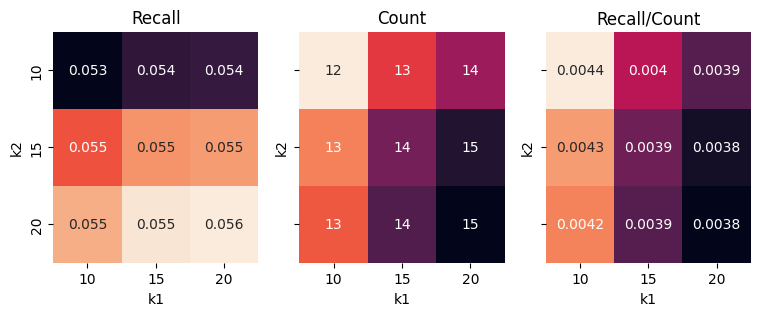

In [134]:
# plot results
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(9, 3))
resss = results[(results.k1 > 5) & (results.k2 > 5)]
sns.heatmap(resss.pivot(columns='k1', index='k2', values='recall'), annot=True, ax=ax1, cbar=False)
sns.heatmap(resss.pivot(columns='k1', index='k2', values='cpu'), cmap='rocket_r', annot=True, ax=ax2, cbar=False)
sns.heatmap(resss.pivot(columns='k1', index='k2', values='tradeoff'), annot=True, ax=ax3, cbar=False)
ax1.set_title('Recall')
ax2.set_title('Count')
ax3.set_title('Recall/Count')

In [394]:
results_all = []
for d1 in [1, 2, 3, 5, 10]:
    for d2 in [1, 2, 3, 5, 10]:
        for r1 in [True, False]:
            for r2 in [True, False]:
                c = candidates_article_feature(bask, train_data, articles, "product_code", 5, 20, d1, d2, r1, r2)
                cpu, rec = metrics(c)
                results_all.append((d1, d2, r1, r2, cpu, rec))

results_all = pd.DataFrame(results_all, columns=['d1', 'd2', 'r1', 'r2', 'cpu', 'recall'])
results_all['tradeoff'] = results_all.recall / results_all.cpu

Text(50.722222222222214, 0.5, 'd2')

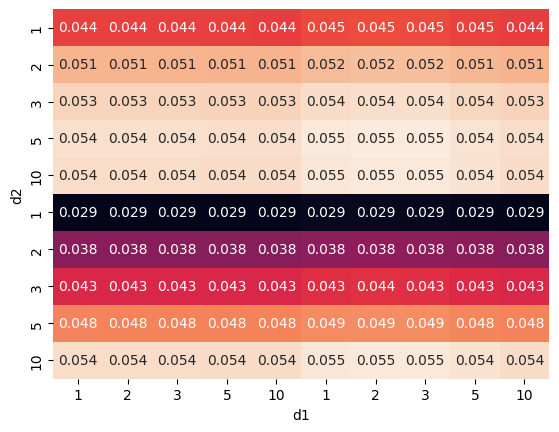

In [531]:
v = 'recall'
a = results_all[results_all.r1 & results_all.r2].pivot(columns='d1', index='d2', values=v)
b = results_all[~results_all.r1 & results_all.r2].pivot(columns='d1', index='d2', values=v)
c = results_all[results_all.r1 & ~results_all.r2].pivot(columns='d1', index='d2', values=v)
d = results_all[~results_all.r1 & ~results_all.r2].pivot(columns='d1', index='d2', values=v)

ax = sns.heatmap(np.block([
    [a.to_numpy(), b.to_numpy()],
    [c.to_numpy(), d.to_numpy()]
]), annot=True, cbar=False)
ax.set_xticklabels([1, 2, 3, 5, 10, 1, 2, 3, 5, 10])
ax.set_yticklabels([1, 2, 3, 5, 10, 1, 2, 3, 5, 10])
ax.set_xlabel('d1')
ax.set_ylabel('d2')

<Axes: xlabel='k', ylabel='recall'>

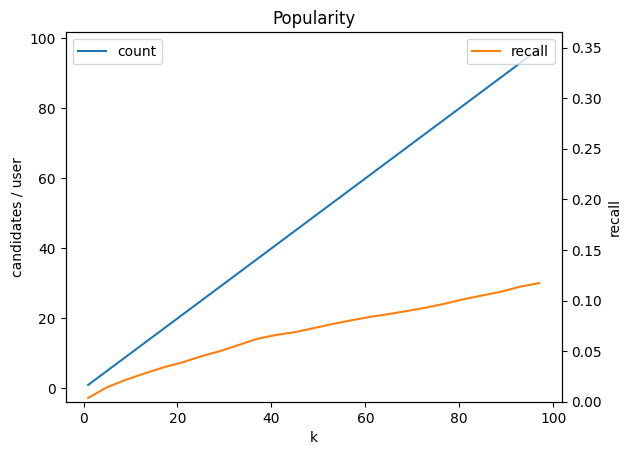

In [103]:
res_age = []
for k in np.arange(1, 100, 4):
    c = candidates_popularity(bask, train_data, k, 1)
    cpu, rec = metrics(c)
    res_age.append((k, cpu, rec))
res_age = pd.DataFrame(res_age, columns=['k', 'count', 'recall'])


<Axes: xlabel='k', ylabel='recall'>

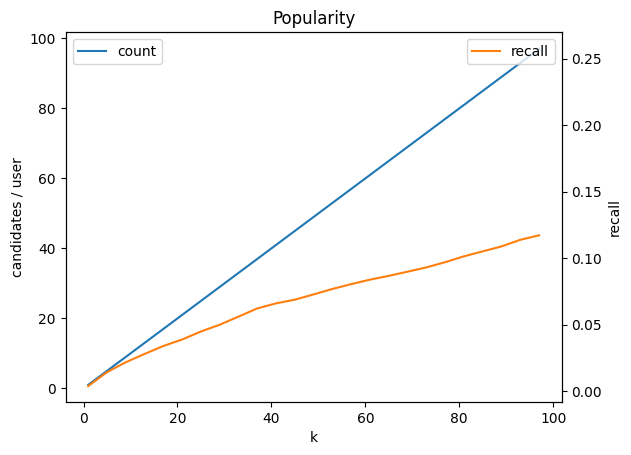

In [122]:
ax1 = res_age[['k', 'count']].plot(x='k', xlabel='k', ylabel='candidates / user', title='Popularity')
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
res_age[['k', 'recall']].plot(x='k', ax=ax2, c='tab:orange', ylabel='recall', ylim=(-0.008, 0.27))

In [153]:
res_pop = []
for d in np.arange(0, 10):
    c1 = candidates_popularity(bask, train_data, 10, d + 1)
    c2 = candidates_customer_feature(bask, train_data, customers, 'age_group', 10, d + 1)
    c3 = candidates_customer_feature(bask, train_data, customers, 'FN', 10, d + 1)
    c4 = candidates_article_feature(bask, train_data, articles, "prod_name", 5, d + 1, 3, 10, False)
    _, rec1 = metrics(c1)
    _, rec2 = metrics(c2)
    _, rec3 = metrics(c3)
    _, rec4 = metrics(c4)
    res_pop.append((d+1, rec1, rec2, rec3, rec4))
res_pop2 = pd.DataFrame(res_pop, columns=['d', 'popularity', 'age_group', 'FN', 'prod_name'])

<Axes: title={'center': 'Recall by # of weeks considered'}, xlabel='d', ylabel='recall'>

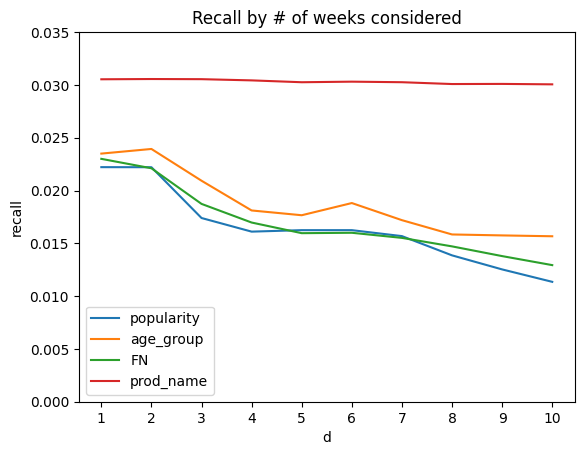

In [155]:
res_pop2.plot(y=['popularity', 'age_group', 'FN', 'prod_name'], x='d', xlabel='d', ylabel='recall', ylim=(0, 0.035), title='Recall by # of weeks considered', xticks=res_pop2.d)